In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, sys

from utils.data_utils import SAMPLING_FREQUENCY, load_data
from custom.models import get_multi_output_model

import tensorflow as tf
from tensorflow import keras

## Prerequisites

Specify the directory where the data is stored.

In [2]:
ROOT_DIR = '/mnt/neurogeriatrics_data/MobiliseD_TVS/rawdata' if sys.platform == 'linux' else 'Z:\\MobiliseD_TVS\\rawdata'

Get train and test data, where the proportion of test data is 20% of the subjects.

In [3]:
train_data, test_data = load_data(path=ROOT_DIR, sequence_length=10., overlap=0., test_size=0.2)

Split the train data into features and labels. For the labels, differentiate between labels for gait sequences and gait events.

In [4]:
train_features, train_labels = train_data[:,:,:-2], train_data[:,:,-2:]
gait_labels = np.expand_dims(train_labels[:,:,0], axis=-1)
event_labels = np.expand_dims(train_labels[:,:,1], axis=-1)
event_labels = keras.utils.to_categorical(event_labels)
print(f'Shape of train features: {train_features.shape}')
print(f'Shape of gait labels: {gait_labels.shape}')
print(f'Shape of event labels: {event_labels.shape}')

Shape of train features: (16592, 640, 12)
Shape of gait labels: (16592, 640, 1)
Shape of event labels: (16592, 640, 5)


Get a multi-output model that simultaneously classifies gait sequences as well as specific gait events.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "tcn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, 12)]   0                                            
____________________________________________________________________________________

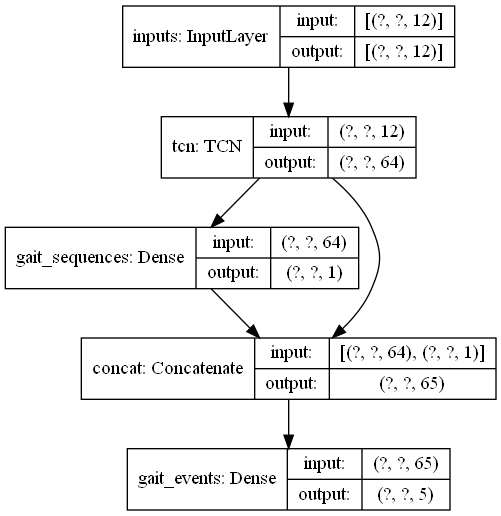

In [5]:
multi_output_model = get_multi_output_model(nb_channels=train_features.shape[-1], nb_classes=event_labels.shape[-1])
multi_output_model.summary()
keras.utils.plot_model(multi_output_model, show_shapes=True)

In [6]:
multi_output_history = multi_output_model.fit(
    x = train_features,
    y = {'gait_sequences': gait_labels,
         'gait_events': event_labels},
    batch_size = 16,
    epochs = 5,
    shuffle = True
)

Epoch 1/5
1037/1037 [==============================] - 516s 498ms/step - loss: 0.1725 - gait_sequences_loss: 0.0908 - gait_events_loss: 0.0817 - gait_sequences_binary_accuracy: 0.9721 - gait_sequences_categorical_accuracy: 1.0000 - gait_events_binary_accuracy: 0.9960 - gait_events_categorical_accuracy: 0.9898
Epoch 2/5
1037/1037 [==============================] - 470s 453ms/step - loss: 0.0595 - gait_sequences_loss: 0.0474 - gait_events_loss: 0.0121 - gait_sequences_binary_accuracy: 0.9833 - gait_sequences_categorical_accuracy: 1.0000 - gait_events_binary_accuracy: 0.9986 - gait_events_categorical_accuracy: 0.9964
Epoch 3/5
1037/1037 [==============================] - 493s 476ms/step - loss: 0.0538 - gait_sequences_loss: 0.0428 - gait_events_loss: 0.0110 - gait_sequences_binary_accuracy: 0.9843 - gait_sequences_categorical_accuracy: 1.0000 - gait_events_binary_accuracy: 0.9986 - gait_events_categorical_accuracy: 0.9966
Epoch 4/5
1037/1037 [==============================] - 497s 479ms/s